## Fault Detection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('data_synchronized.csv')

# Define columns for each room
rooms = {
    'kitchen': {
        'temperature': 'temp_zt_kitchen',
        'setpoint': 'sp_kitchen',
        'valvepos': 'valvepos_kitchen'
        },
    
    'dining room': {
    'temperature': 'temp_zt_diningroom',
    'setpoint': 'sp_diningroom',
    'valvepos': 'valvepos_diningroom'
    },
    
    'living room': {
        'temperature': 'temp_zt_livingroom',
        'setpoint': 'sp_livingroom',
        'valvepos': 'valvepos_livingroom'
    }
}

Thermal Comfort Rule Applied:
- A thermal discomfort is flagged when the actual room temperature deviates from the set point by more than ±1.5°C for more than 15 minutes.

In [2]:
# Define the thermal discomfort rule

def detect_discomfort(data, room):
    discomfort_periods = []
    temp_col = rooms[room]['temperature']
    sp_col = rooms[room]['setpoint']

    for i in range(len(data)):
     if abs(data[temp_col][i] - data[sp_col][i]) > 1.5:
        discomfort_periods.append(i)
        
    return discomfort_periods


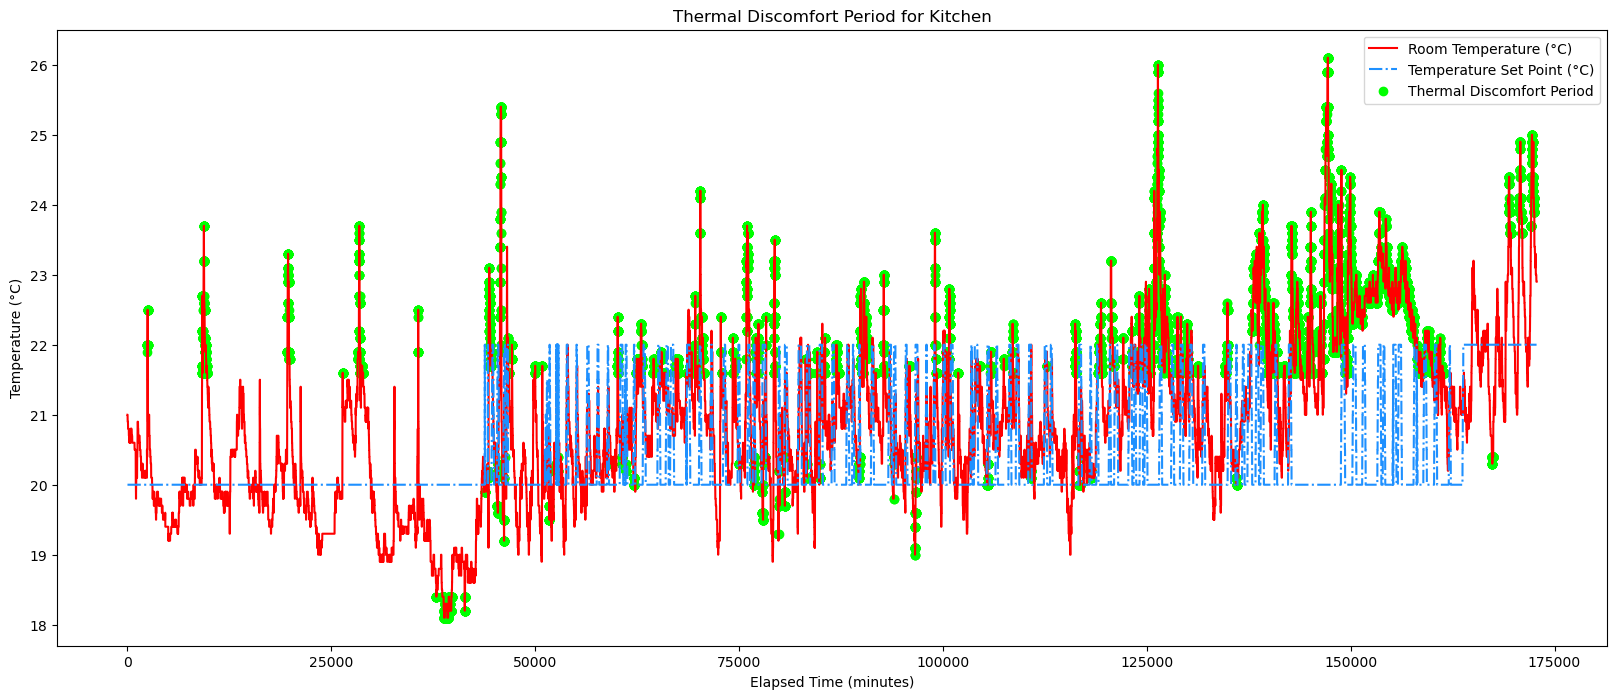

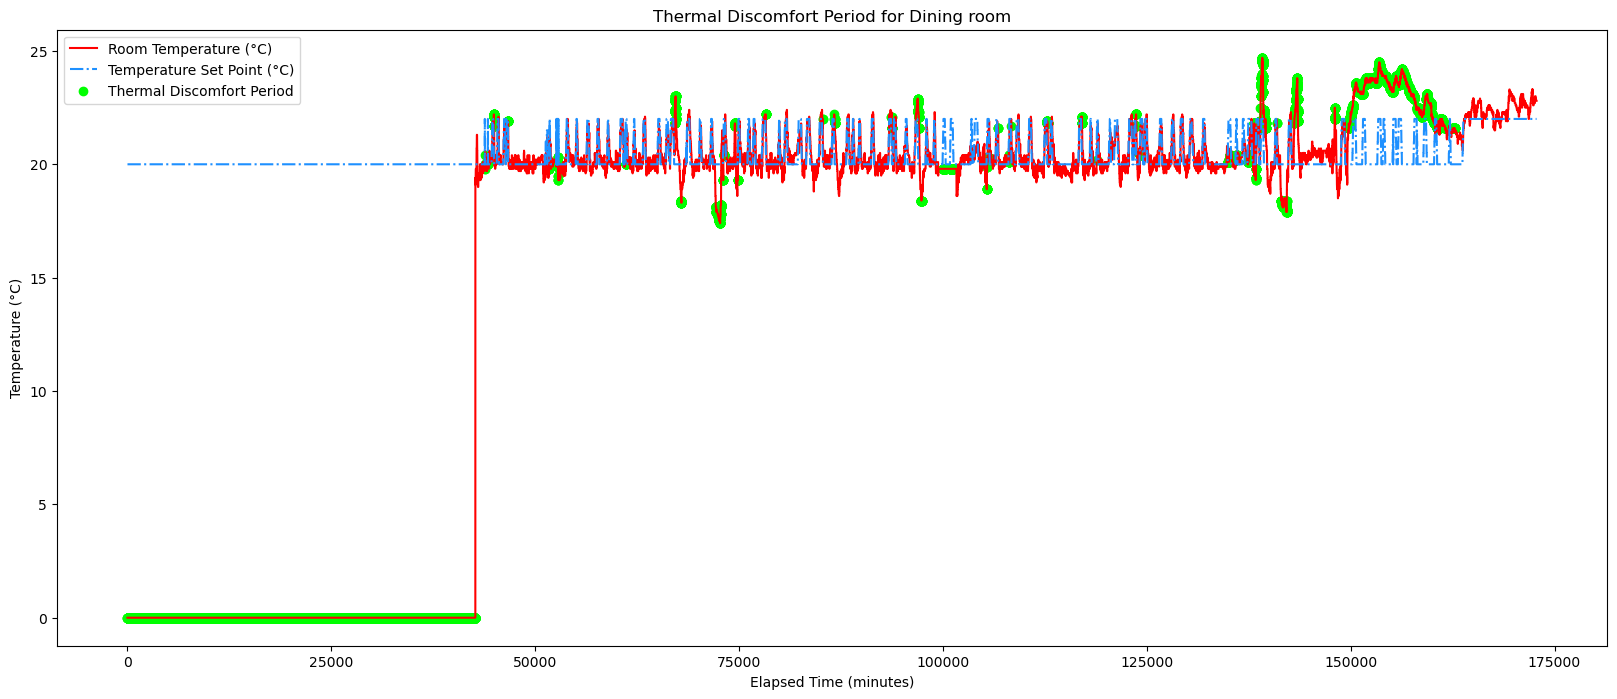

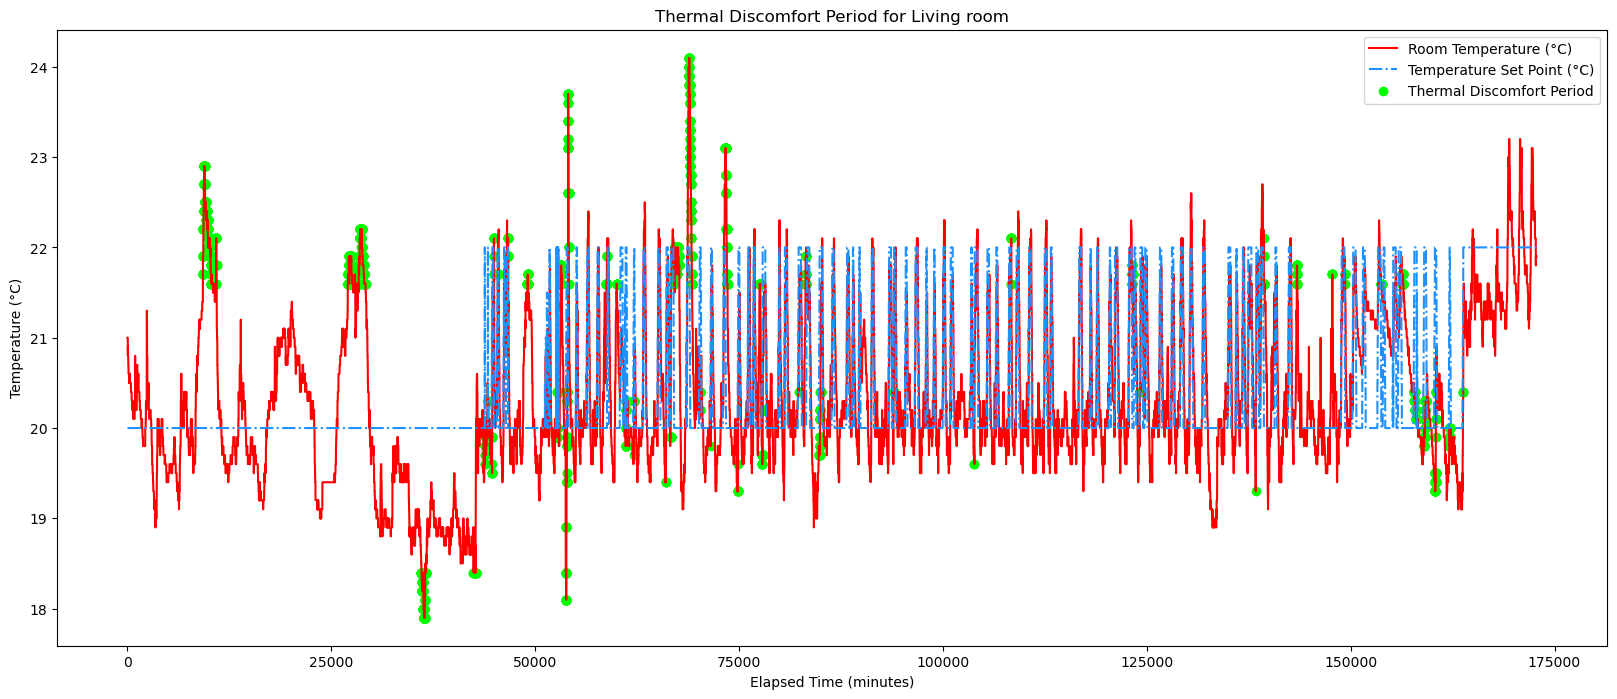

Time series plots generated and saved for each room.


In [3]:
# Plot time series for each room
for room in rooms:
    temp_col = rooms[room]['temperature']
    sp_col = rooms[room]['setpoint']
    # valvepos_col = rooms[room]['valvepos']

    discomfort_periods = detect_discomfort(data, room)
    plt.figure(figsize=(20, 8))
    plt.plot(data[temp_col], label='Room Temperature (°C)', color='red')
    plt.plot(data[sp_col], label='Temperature Set Point (°C)', color='dodgerblue', linestyle='dashdot')
    # plt.plot(data[valvepos_col], label='Valve Position', color='silver')

    plt.scatter(discomfort_periods, data[temp_col][discomfort_periods], color='lime', label='Thermal Discomfort Period')

    
    plt.title(f'Thermal Discomfort Period for {room.capitalize()}')
    plt.xlabel('Elapsed Time (minutes)')
    plt.ylabel("Temperature (°C)")
    # plt.ylim(0, 27)
    plt.legend()
    # plt.grid(True)
    # plt.savefig(f'{room.replace(" ", "_")}_thermal_discomfort.png')
    plt.show()

print("Time series plots generated and saved for each room.")

## Fault Detection Rules

Fault Detection Rules Implemented:
- Valve Ineffectiveness: Valve is open >90% but temperature is still >1.5°C below set point.
- Controller Instability: Set point changes more than 3 times within 60 minutes.
- Sensor Fault: Sudden jumps >5°C or flatlines for over 60 minutes.
- Overheating: Temperature exceeds set point by >1.5°C while valve is <10%.

Each rule is implemented separately, and the plots display where it is triggered.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('data_synchronized.csv')

# Define the columns for each room
rooms = {
    'kitchen': {
        'temp': 'temp_zt_kitchen',
        'set_point': 'sp_kitchen',
        'valve_pos': 'valvepos_kitchen'
    },
    'dining_room': {
        'temp': 'temp_zt_diningroom',
        'set_point': 'sp_diningroom',
        'valve_pos': 'valvepos_diningroom'
    },
    'living_room': {
        'temp': 'temp_zt_livingroom',
        'set_point': 'sp_livingroom',
        'valve_pos': 'valvepos_livingroom'
    }
}

# Convert timestamps to elapsed time in minutes
data['elapsed_time'] = (pd.to_datetime(data['Timestamps']) - pd.to_datetime(data['Timestamps'][0])).dt.total_seconds() / 60

In [5]:
# Function to plot data with fault detection markers
def plot_fault_detection(room_name, room_data, fault_indices, fault_type):
    plt.figure(figsize=(20, 8))
    plt.plot(room_data['elapsed_time'], room_data[room_cols['temp']], label='Room Temperature (°C)', color='red')
    plt.plot(room_data['elapsed_time'], room_data[room_cols['set_point']], label='Set Point Temperature (°C)', color='dodgerblue', linestyle='dashdot')
    # plt.plot(room_data['elapsed_time'], room_data[room_cols['valve_pos']], label='Valve Position (%)', color='green')
    plt.scatter(room_data['elapsed_time'].iloc[fault_indices], room_data[room_cols['temp']].iloc[fault_indices], color='lime', label=f'{fault_type} Fault', s=50)
    plt.xlabel('Elapsed Time (minutes)')
    plt.ylabel('Temperature (°C)')

    # plt.ylim(0, 27)

    plt.title(f'{fault_type} Fault Detection in {room_name.replace("_", " ").title()}')
    plt.legend()
    # plt.grid(True)
    plt.show()

- Valve Ineffectiveness: Valve is open >90% but temperature is still >1.5°C below set point.

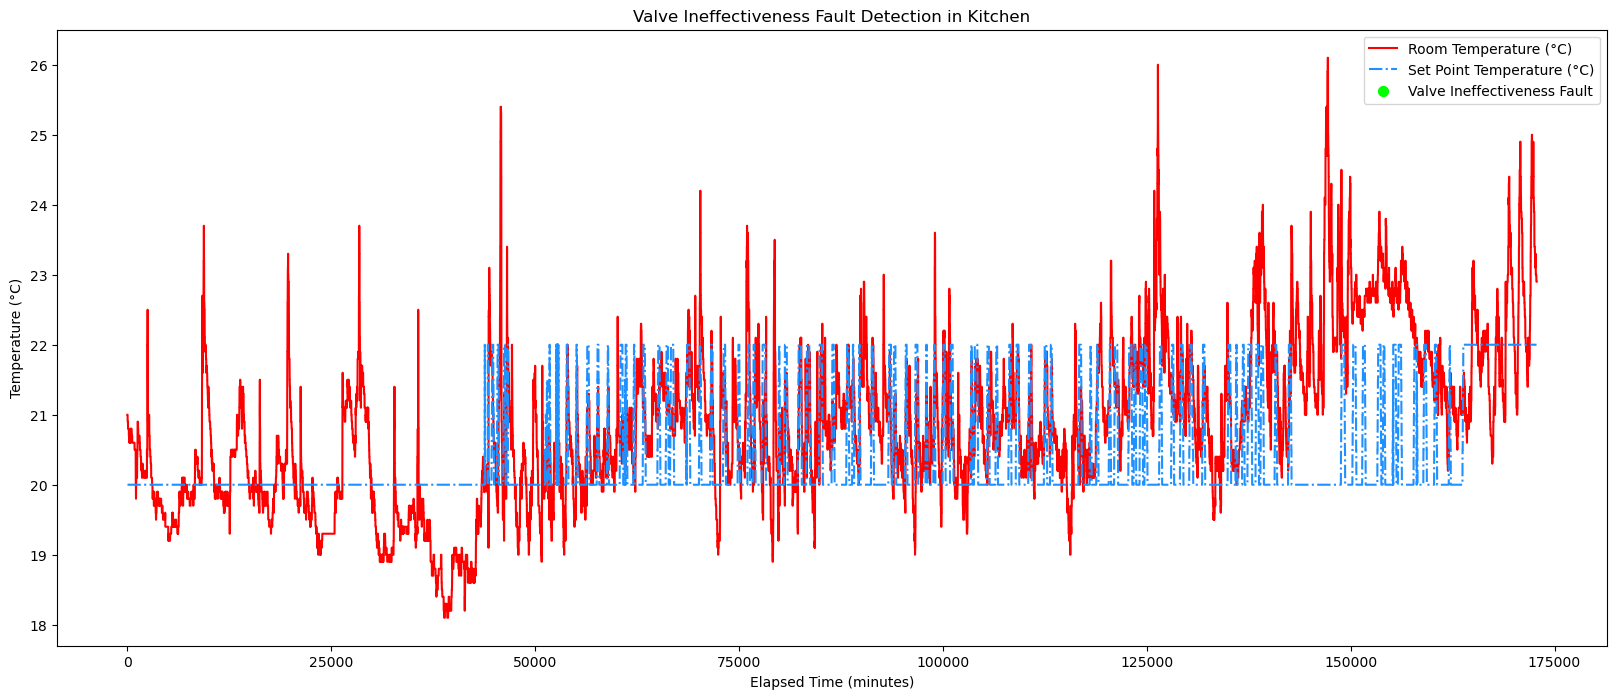

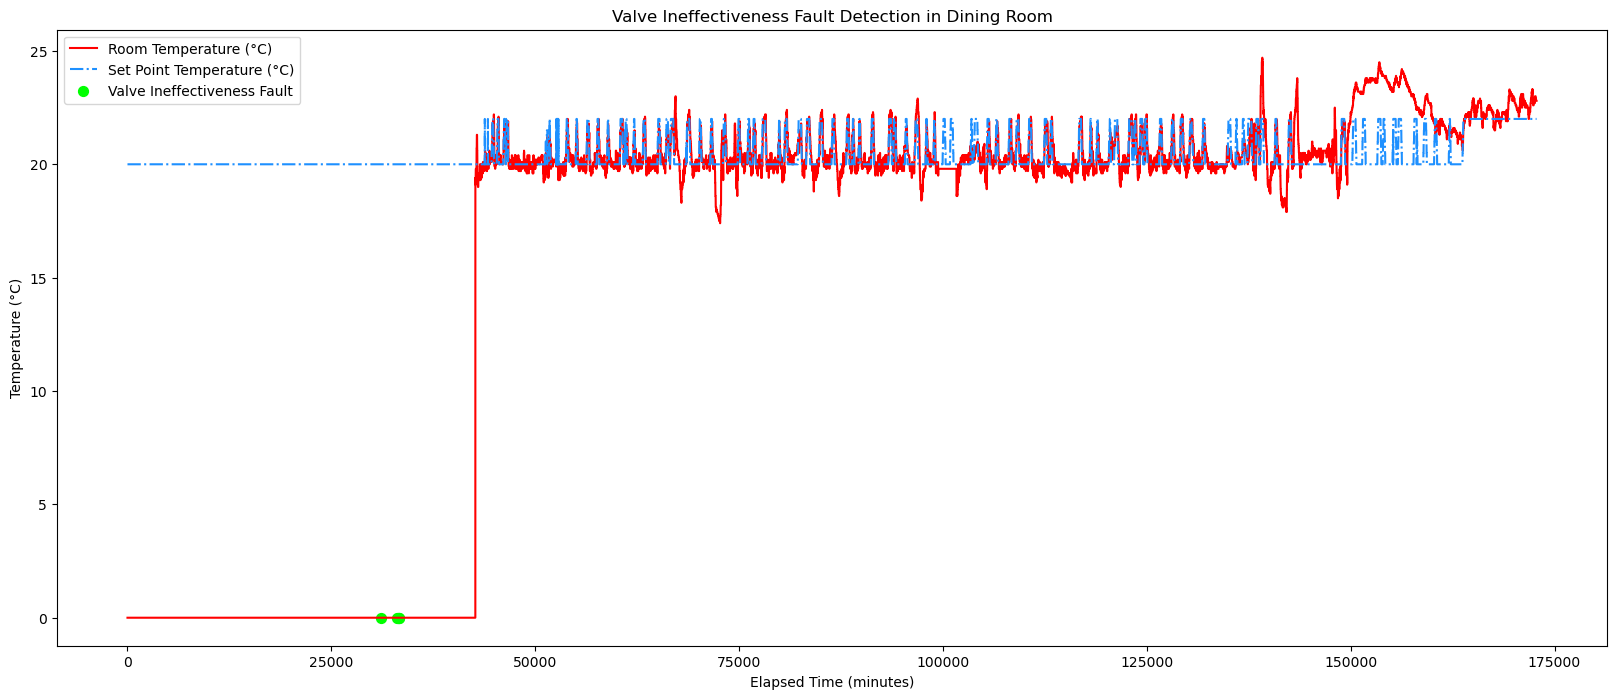

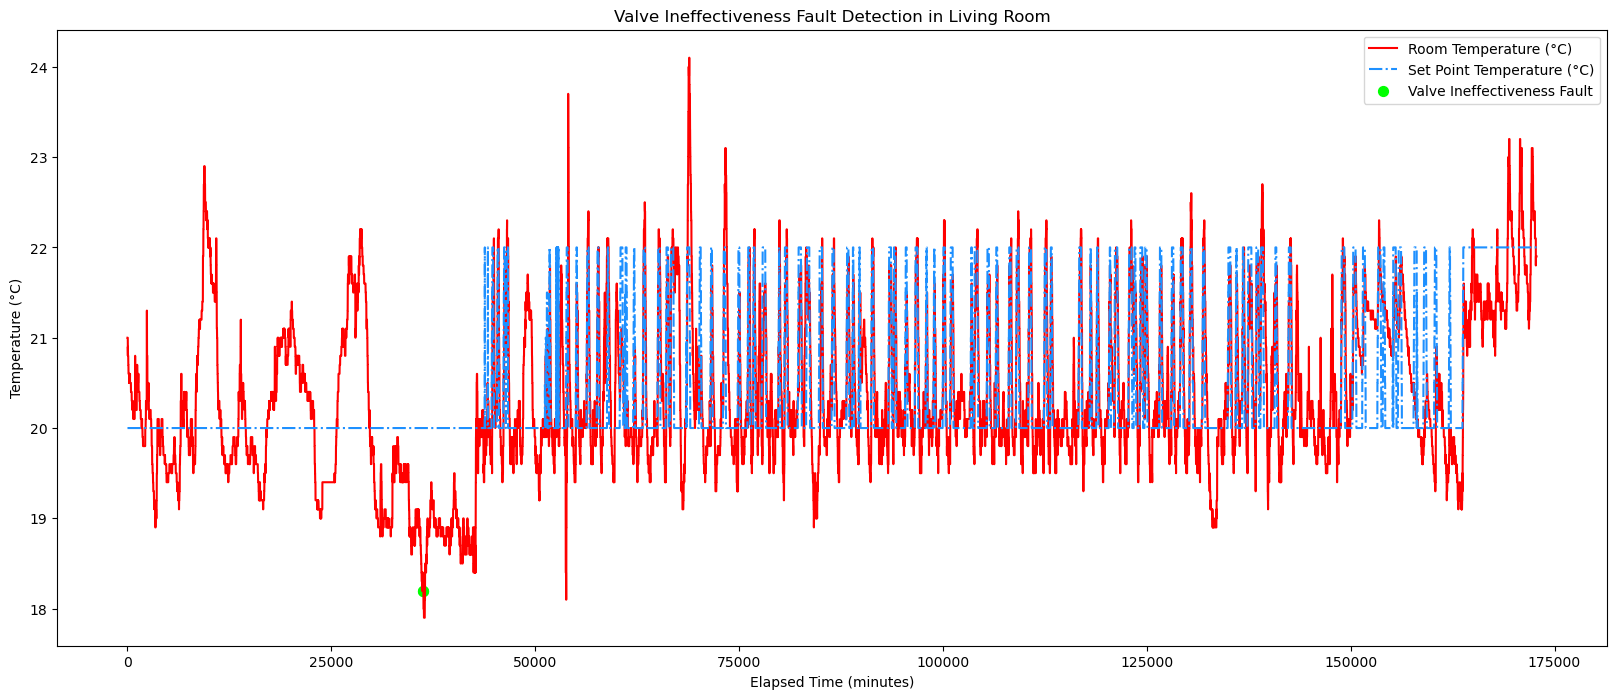

In [6]:
# Rule 1: Valve Ineffectiveness
for room_name, room_cols in rooms.items():
    room_data = data[['elapsed_time', room_cols['temp'], room_cols['set_point'], room_cols['valve_pos']]]
    fault_indices = room_data[(room_data[room_cols['valve_pos']] > 90) & ((room_data[room_cols['set_point']] - room_data[room_cols['temp']]) > 1.5)].index
    plot_fault_detection(room_name, room_data, fault_indices, 'Valve Ineffectiveness')


- Controller Instability: Set point changes more than 3 times within 60 minutes.

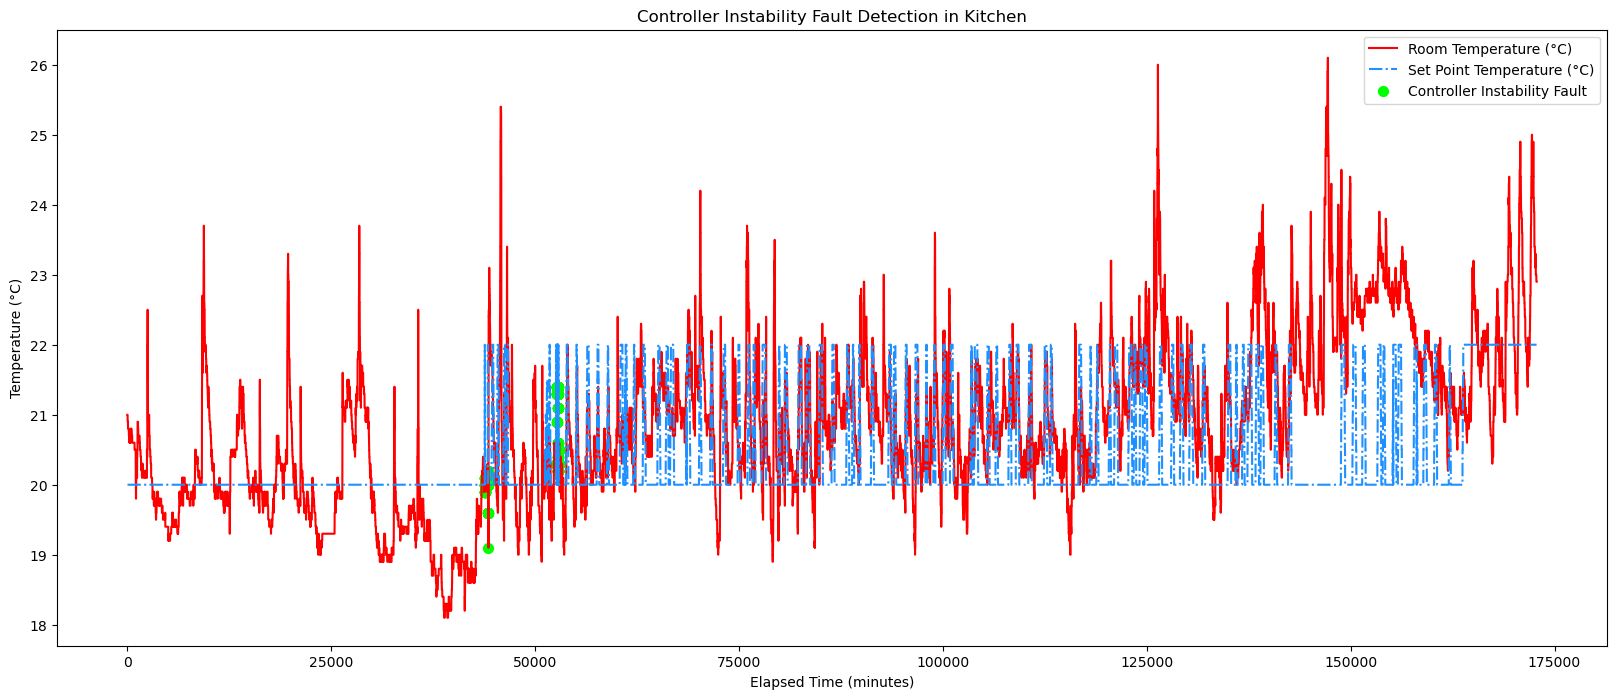

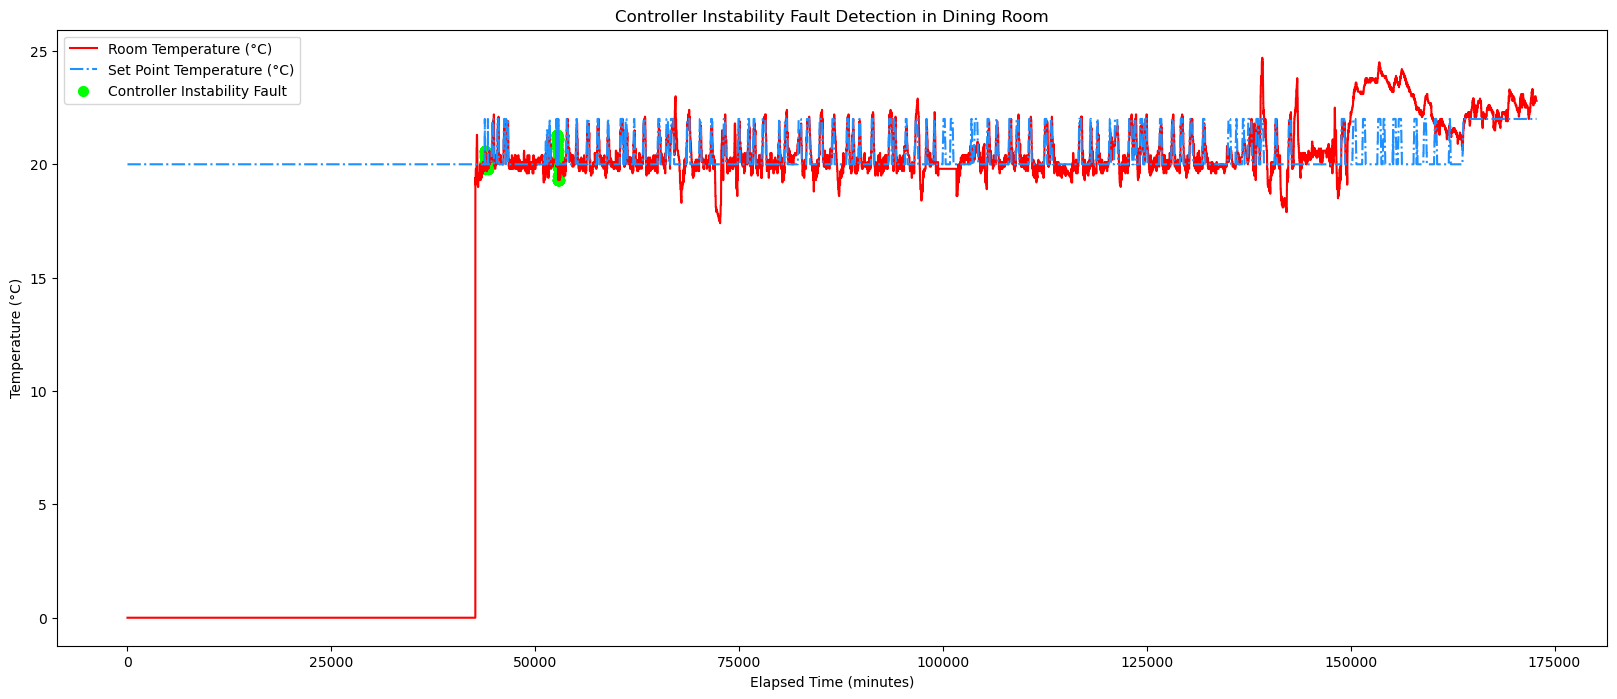

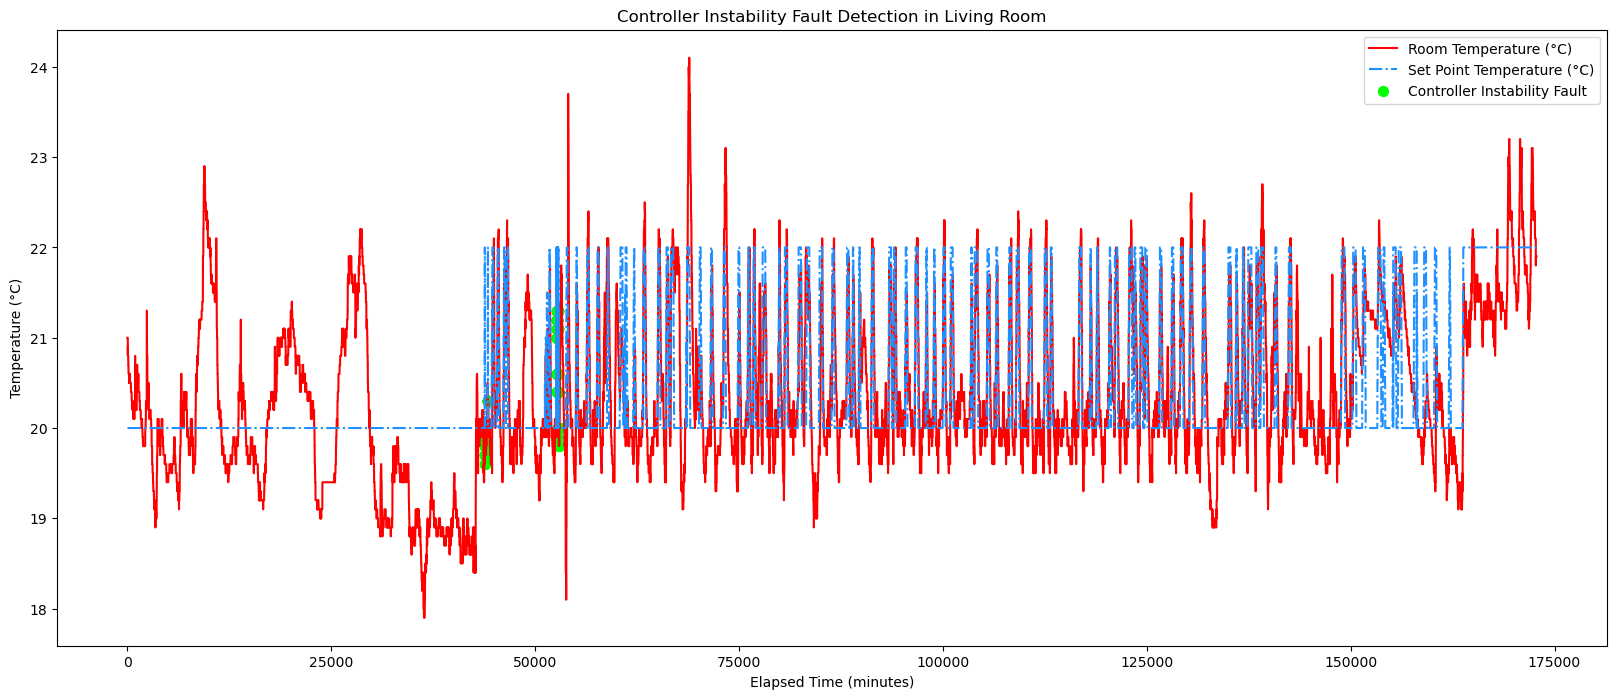

In [7]:
# Rule 2: Controller Instability
for room_name, room_cols in rooms.items():
    room_data = data[['elapsed_time', room_cols['temp'], room_cols['set_point'], room_cols['valve_pos']]]
    set_point_changes = room_data[room_cols['set_point']].diff().abs() > 0
    fault_indices = set_point_changes.rolling(window=60).sum() > 3
    plot_fault_detection(room_name, room_data, fault_indices[fault_indices].index, 'Controller Instability')

- Sensor Fault: Sudden jumps >5°C or flatlines for over 60 minutes.

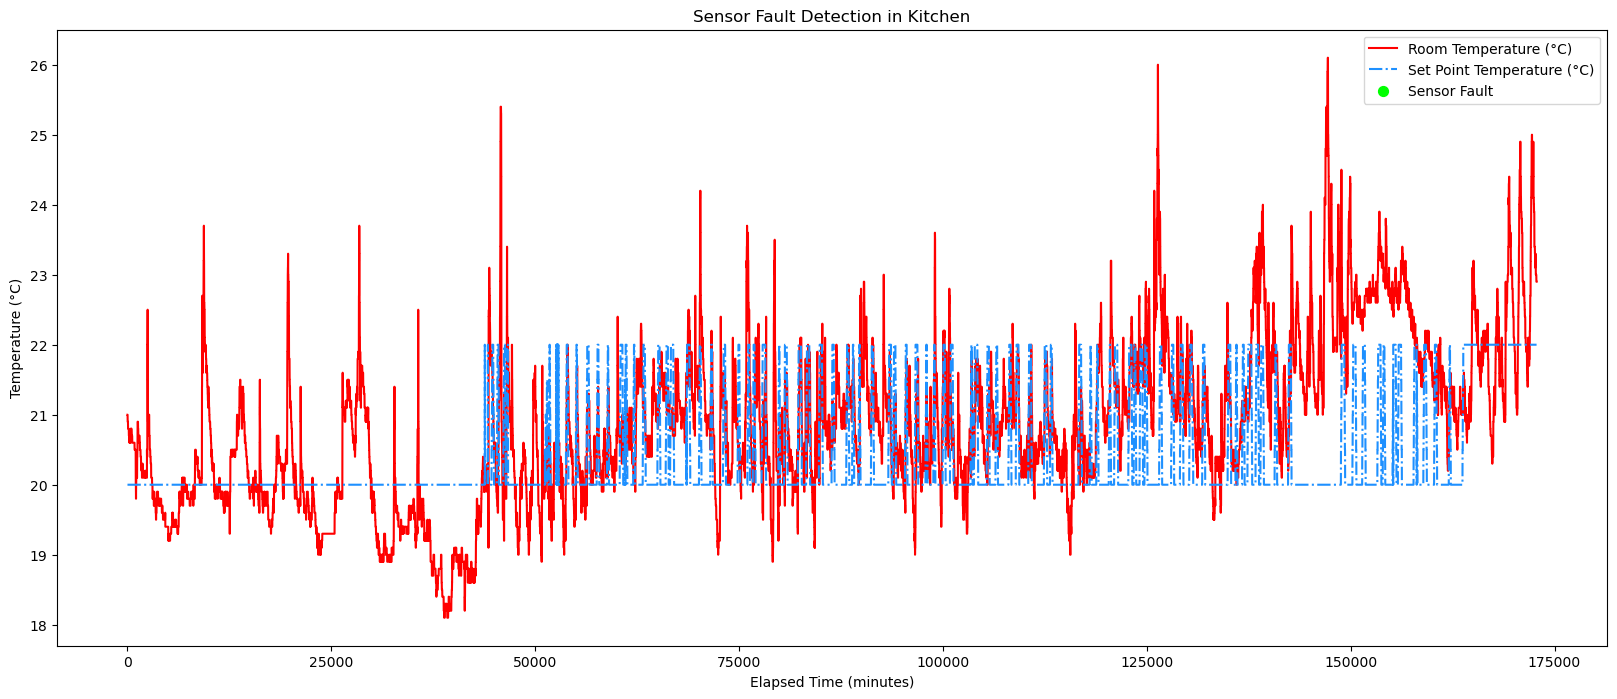

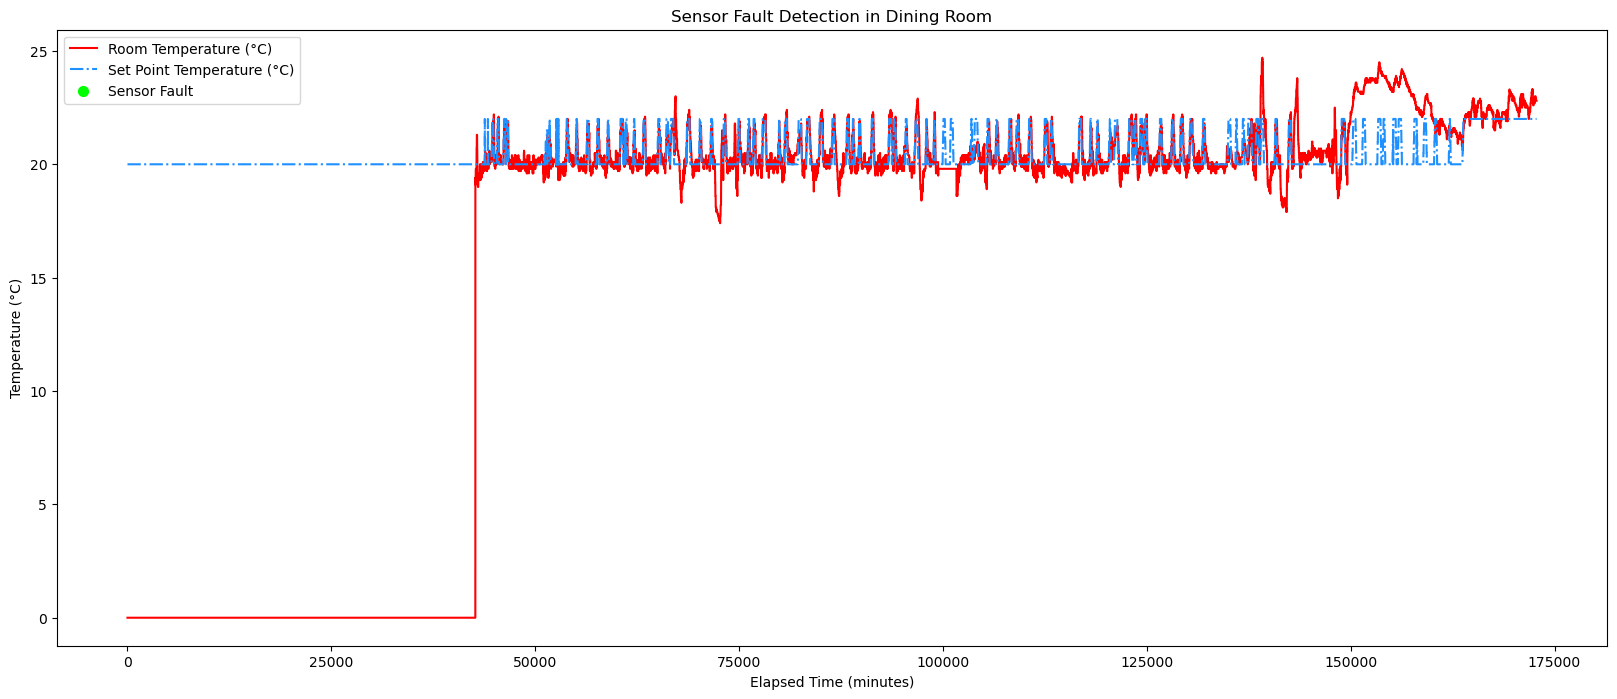

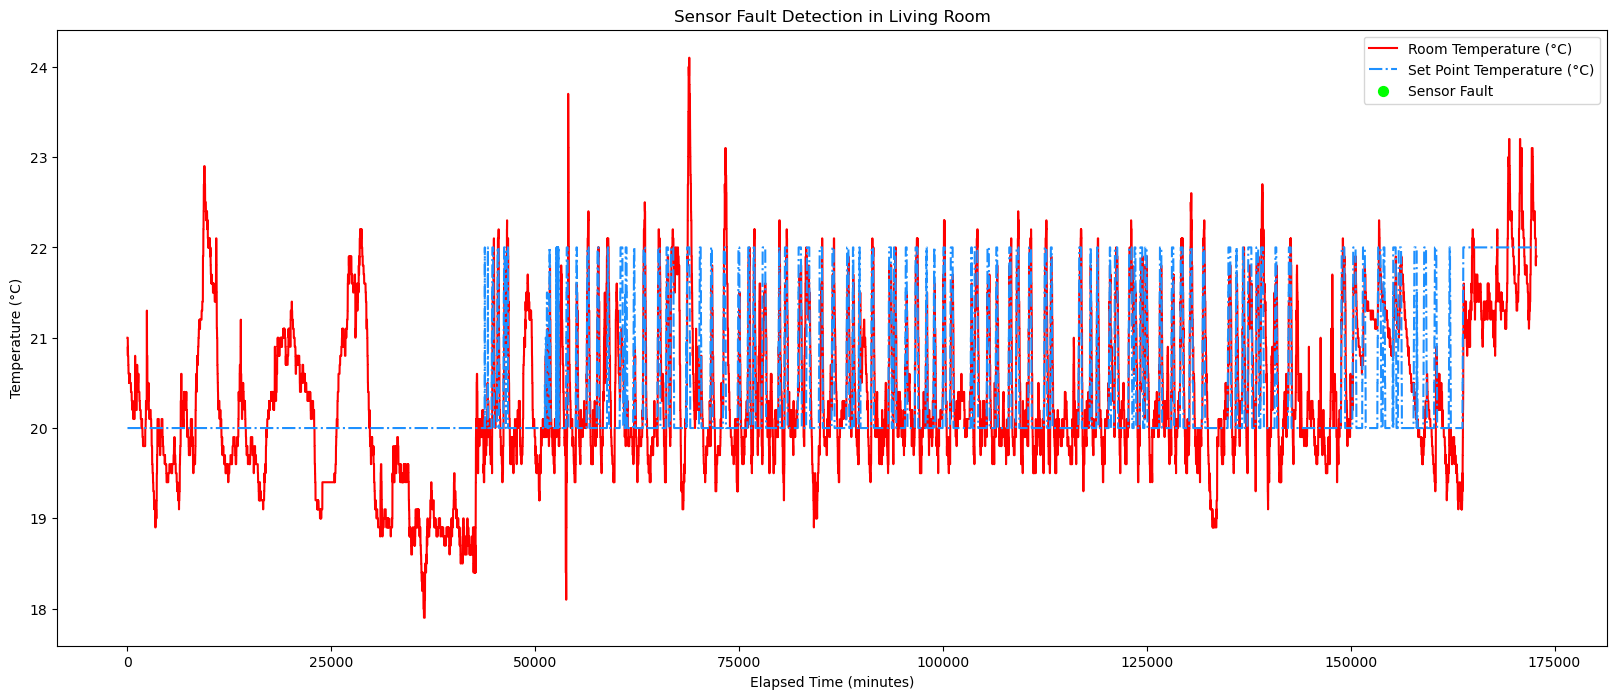

In [8]:
# Rule 3: Sensor Faults
for room_name, room_cols in rooms.items():
    room_data = data[['elapsed_time', room_cols['temp'], room_cols['set_point'], room_cols['valve_pos']]]
    sudden_jumps = room_data[room_cols['temp']].diff().abs() > 5
    flatlines = room_data[room_cols['temp']].diff().abs() == 0
    fault_indices = sudden_jumps | flatlines.rolling(window=60).sum() > 60
    plot_fault_detection(room_name, room_data, fault_indices[fault_indices].index, 'Sensor')

- Overheating: Temperature exceeds set point by >1.5°C while valve is <10%.

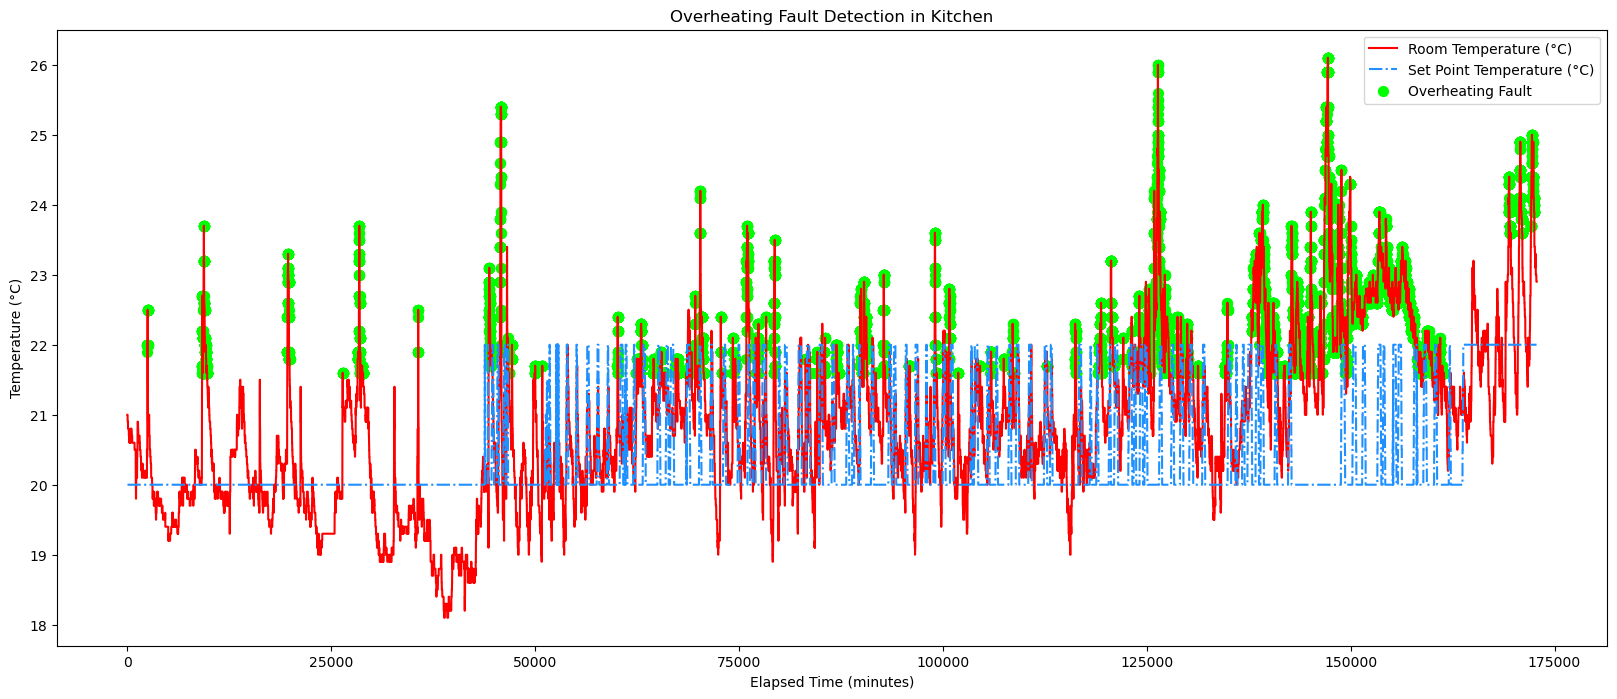

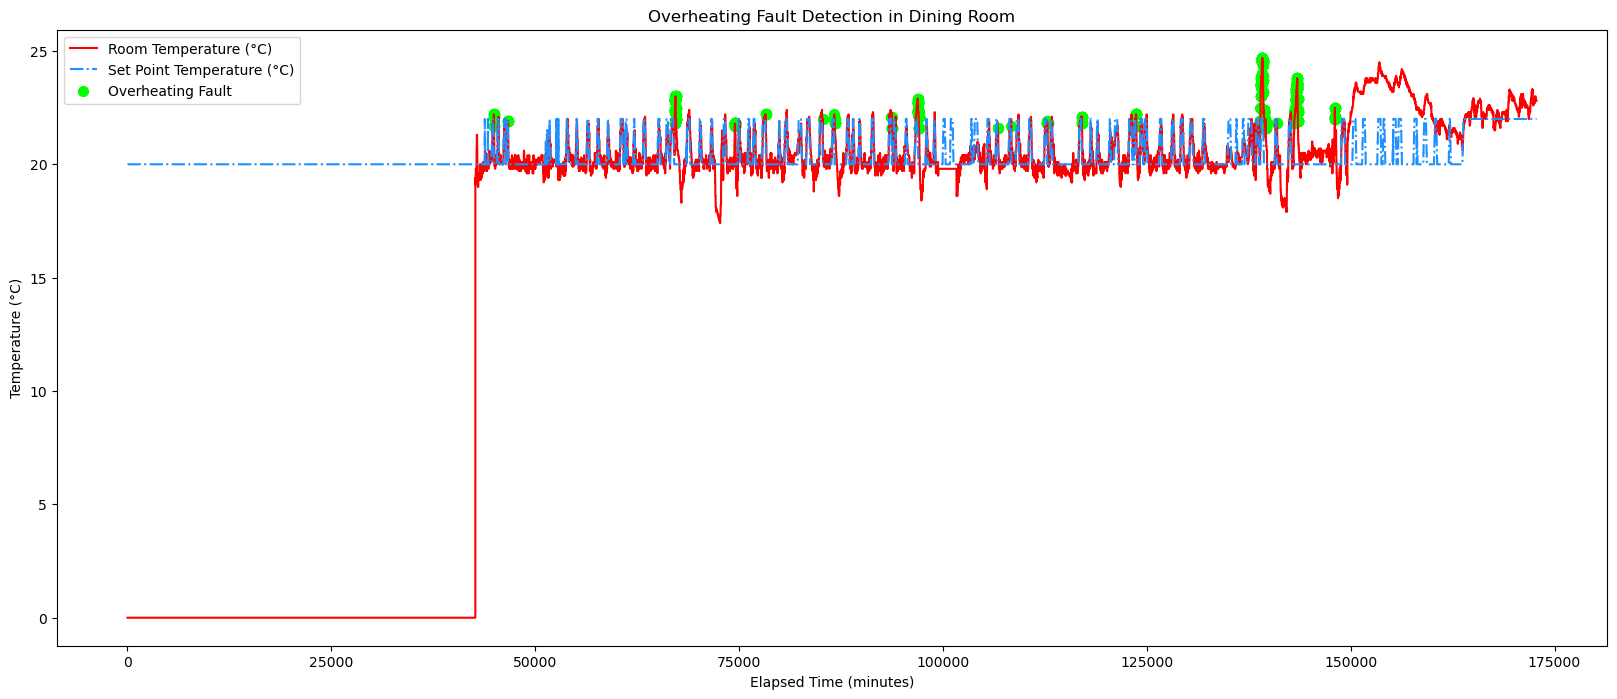

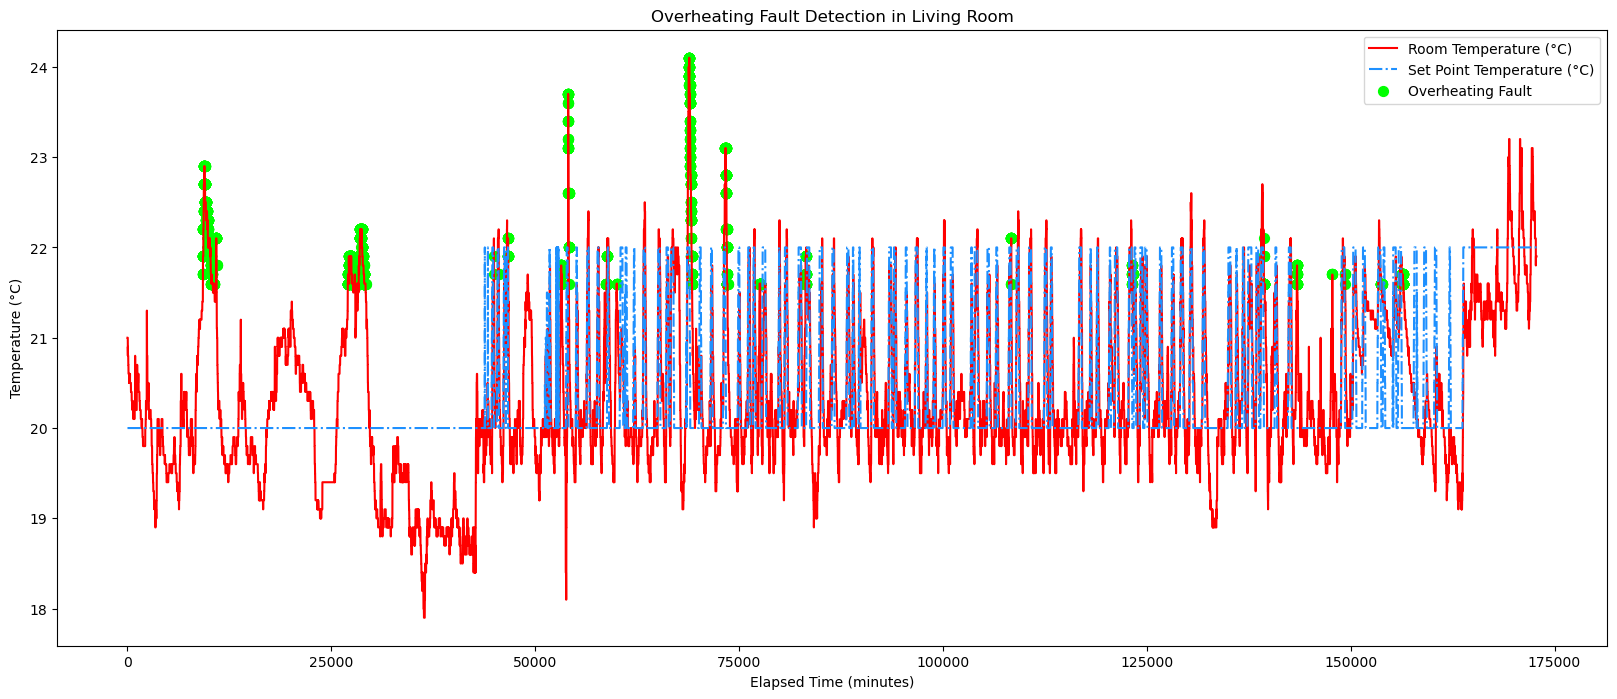

In [9]:
# Rule 4: Overheating
for room_name, room_cols in rooms.items():
    room_data = data[['elapsed_time', room_cols['temp'], room_cols['set_point'], room_cols['valve_pos']]]
    fault_indices = room_data[(room_data[room_cols['temp']] > room_data[room_cols['set_point']] + 1.5) & (room_data[room_cols['valve_pos']] < 10)].index
    plot_fault_detection(room_name, room_data, fault_indices, 'Overheating')